/tmp/ipykernel_139223/2777394058.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


Error: x and y lengths do not match
Error: x and y lengths do not match
Error: x and y lengths do not match


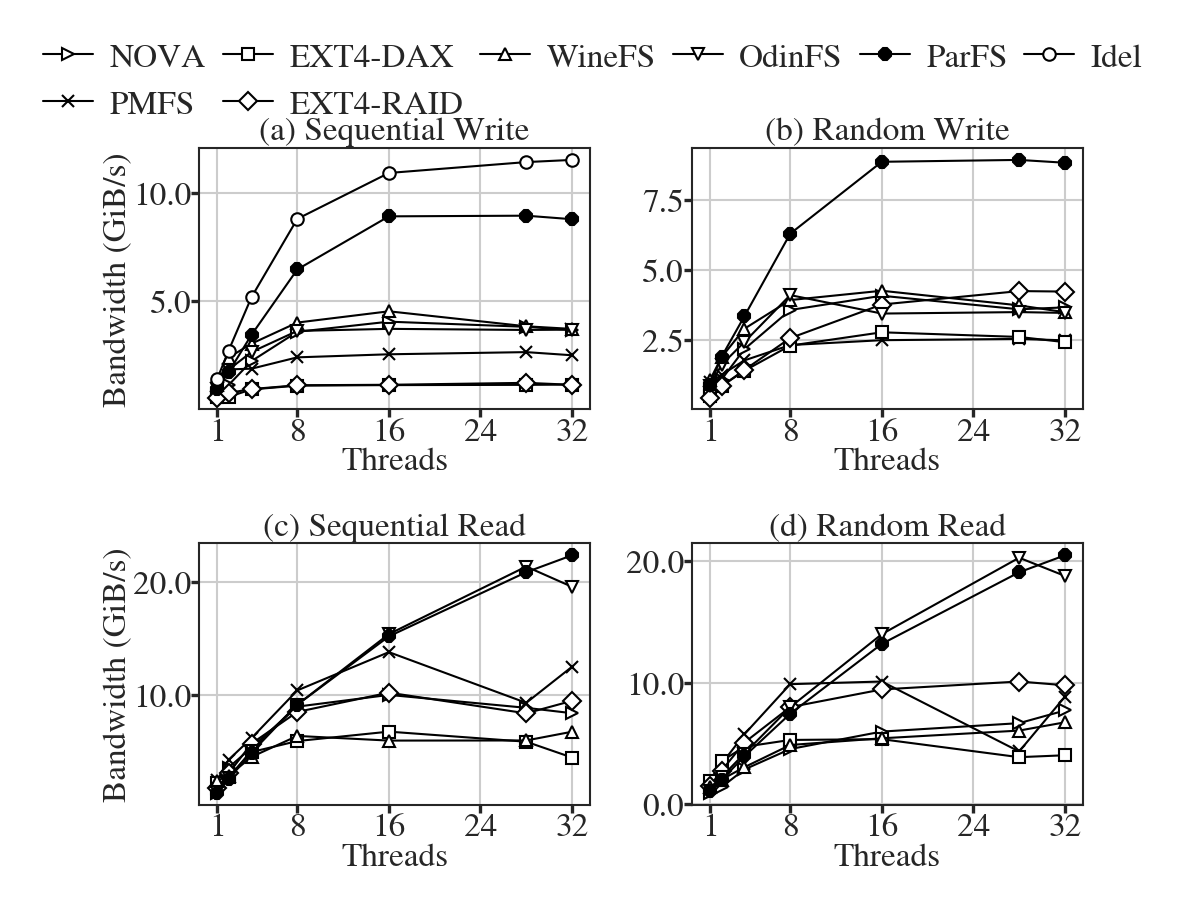

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-v0_8-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 8
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table-restore1-4k", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(7)))

line_width = 0.5
# marks = [">", "x", "s", "D", "o", "o"]
marks = [">", "x", "s", "D", "^", "v","8", "o"]
fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
# fss = ["NOVA", "PMFS", "SplitFS-FIO", "MadFS", "EXT4-DAX", "SLOTFS"]
fss = ["nova", "pmfs", "ext4-dax", "ext4-raid", "winefs", "odinfs-12", "parfs-12", "idel"]
# num_jobs = range(1, 17)  
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs) 
ops = ["write", "randwrite", "read", "randread"]
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024
titles = ["(a) Sequential Write", "(b) Random Write", "(c) Sequential Read", "(d) Random Read"]
lines = []

mapping = {
    "nova":"NOVA",
    "pmfs":"PMFS",
    "ext4-dax":"EXT4-DAX",
    "ext4-raid":"EXT4-RAID",
    "winefs":"WineFS",
    "odinfs-12":"OdinFS",
    "parfs-12":"ParFS",
    "idel":"Idel"
}
mapped_fss = [mapping.get(item, item) for item in fss]


for i in range(4):
    plt.subplot(2, 2, i + 1)
    op = ops[i]
    for idx, fs in enumerate(fss):
        y = df[(df['fs'] == fs) & (df['ops'] == op)]['bandwidth'].iloc[:len(num_jobs)]
        if fs == "parfs-12":
            markercoler = "black"
        else:
            markercoler = "white"
        
        if (len(x) != len(y)):
            print("Error: x and y lengths do not match")
            continue
        
        p, = plt.plot(x, y, color="black", markerfacecolor=markercoler, linewidth=line_width,label=fs, marker=marks[idx], markeredgecolor="black", markersize=3, markeredgewidth=0.5)
        #plt.scatter(x, y, color="white", s=0.3)
        lines.append(p)

    # if i == 3:
    #     plt.yticks([0, 2.0, 4.0, 6.0, 8.0])
    # else:
    #     plt.yticks([0, 0.6, 1.2, 1.8, 2.4])
    if i == 0 or i == 2:
        plt.ylabel('Bandwidth (GiB/s)', labelpad=-0.02)

    plt.title(titles[i], fontsize=8, pad=2)
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

    plt.xlabel("Threads", labelpad=-0.02) 
    # plt.xticks([1,4,8,12,16])
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32])
    ax = plt.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

    plt.tick_params(axis='y', pad=0)
    plt.tick_params(axis='x', pad=0)

    ax = plt.gca()
    ax.tick_params(axis='y', which='major', length=2, direction='out', right=False, left=True)
    ax.tick_params(axis='x', which='major', length=2, direction='out', top=False, bottom=True)
    ax.yaxis.set_tick_params(which='major', size=2)
    
fig.legend(lines, mapped_fss, loc='center', bbox_to_anchor=(0.5, 1), ncol=6, columnspacing=0.5, handletextpad=0.5, handlelength=1.5, frameon=False)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.34, wspace=0.07)

plt.tight_layout()

plt.savefig("./FIO-MT.pdf", bbox_inches='tight', pad_inches=0.05)


/tmp/ipykernel_137864/18670304.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


Data mismatch: idel read 4096
Data mismatch: idel read 32768
Data mismatch: idel randwrite 4096
Data mismatch: idel randwrite 8192
Data mismatch: idel randwrite 16384
Data mismatch: idel randwrite 32768
Data mismatch: idel randread 4096
Data mismatch: idel randread 32768


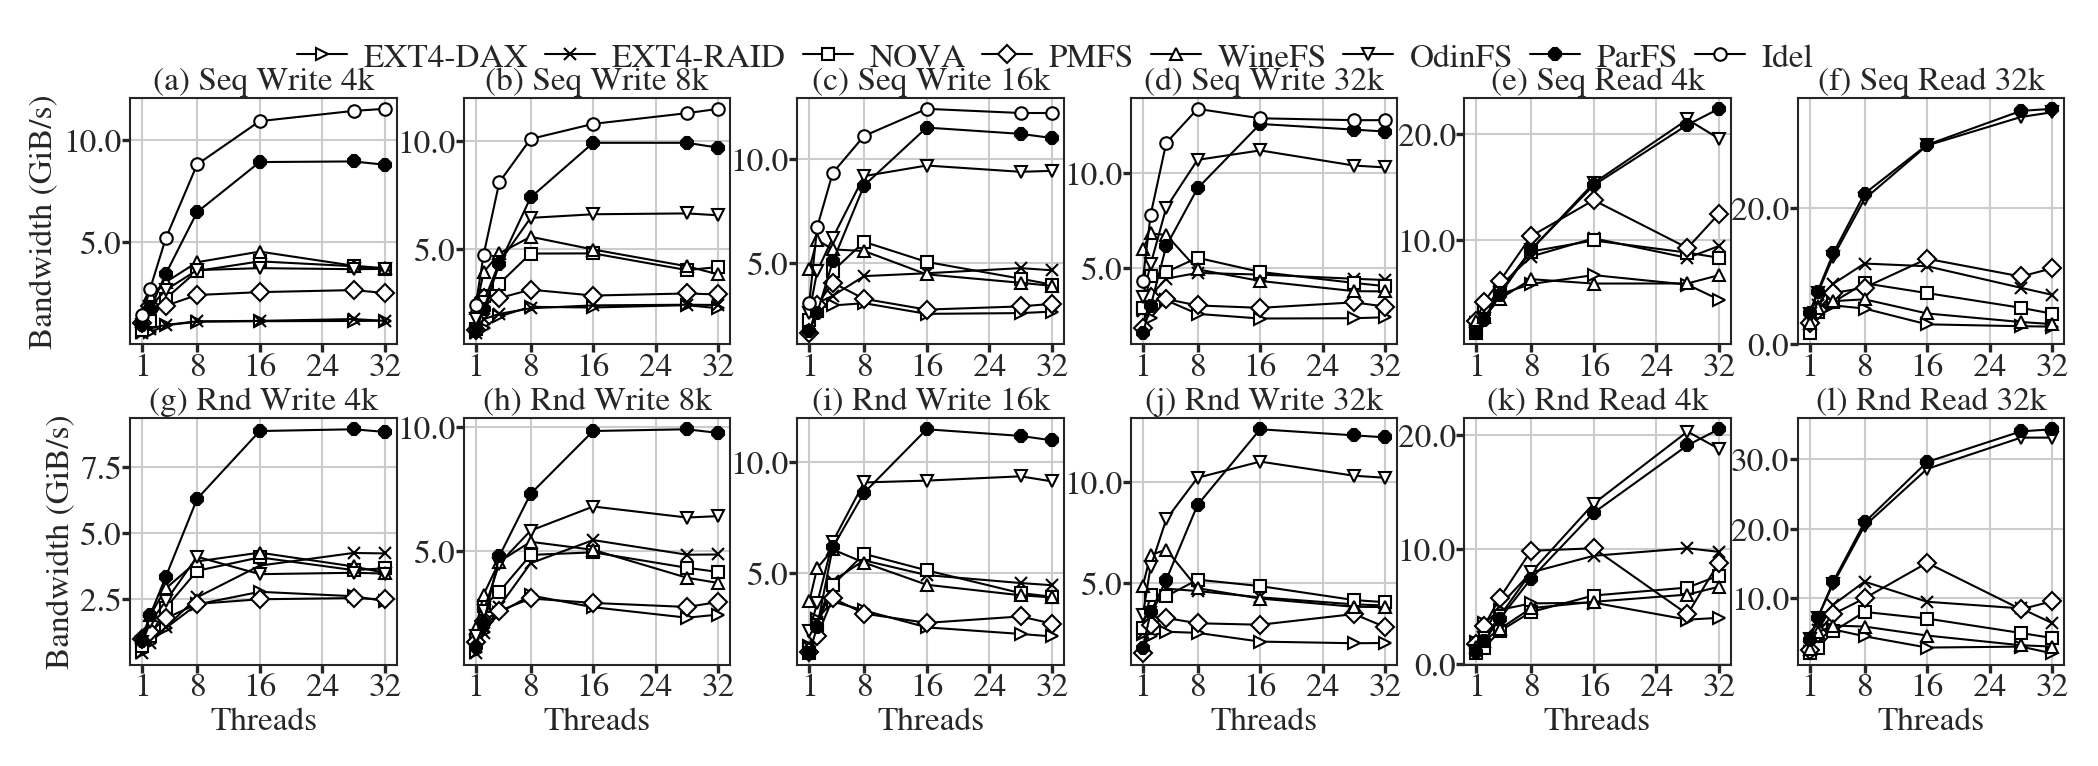

In [3]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-v0_8-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 8
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table-restore1", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi=300, figsize=(cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(6)))

line_width = 0.5
marks = [">", "x", "s", "D", "^", "v", "8", "o"]
fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs)
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024

mapping = {
    "nova": "NOVA",
    "pmfs": "PMFS",
    "ext4-dax": "EXT4-DAX",
    "ext4-raid": "EXT4-RAID",
    "winefs": "WineFS",
    "odinfs-12": "OdinFS",
    "parfs-12": "ParFS",
    "idel": "Idel"
}
mapped_fss = [mapping.get(item, item) for item in fss]

subplot_config = [
    # Upper row
    {'row': 0, 'col': 0, 'op': 'write', 'blksz': 4096, 'title_label': 'a'},
    {'row': 0, 'col': 1, 'op': 'write', 'blksz': 8192, 'title_label': 'b'},
    {'row': 0, 'col': 2, 'op': 'write', 'blksz': 16384, 'title_label': 'c'},
    {'row': 0, 'col': 3, 'op': 'write', 'blksz': 32768, 'title_label': 'd'},
    {'row': 0, 'col': 4, 'op': 'read', 'blksz': 4096, 'title_label': 'e'},
    {'row': 0, 'col': 5, 'op': 'read', 'blksz': 32768, 'title_label': 'f'},
    # Lower row
    {'row': 1, 'col': 0, 'op': 'randwrite', 'blksz': 4096, 'title_label': 'g'},
    {'row': 1, 'col': 1, 'op': 'randwrite', 'blksz': 8192, 'title_label': 'h'},
    {'row': 1, 'col': 2, 'op': 'randwrite', 'blksz': 16384, 'title_label': 'i'},
    {'row': 1, 'col': 3, 'op': 'randwrite', 'blksz': 32768, 'title_label': 'j'},
    {'row': 1, 'col': 4, 'op': 'randread', 'blksz': 4096, 'title_label': 'k'},
    {'row': 1, 'col': 5, 'op': 'randread', 'blksz': 32768, 'title_label': 'l'},
]

op_type_map = {
    'write': 'Seq Write',
    'randwrite': 'Rnd Write',
    'read': 'Seq Read',
    'randread': 'Rnd Read'
}

blksz_str_map = {
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k'
}

lines = []
for i, config in enumerate(subplot_config):
    plt.subplot(2, 6, i+1)
    op = config['op']
    blksz = config['blksz']
    
    op_type = op_type_map[op]
    blksz_str = blksz_str_map[blksz]
    plt.title(f"({config['title_label']}) {op_type} {blksz_str}", fontsize=8, pad=2)
    
    for fs_idx, fs in enumerate(fss):
        data = df[(df['fs'] == fs) & (df['ops'] == op) & (df['blksz'] == blksz)]
        y = data['bandwidth'].iloc[:len(num_jobs)]
        
        if len(x) != len(y):
            print(f"Data mismatch: {fs} {op} {blksz}")
            continue
        
        markercolor = "black" if fs == "parfs-12" else "white"
        
        if i == 0:  # Only add labels to first subplot
            p, = plt.plot(x, y, color="black", marker=marks[fs_idx],
                          markerfacecolor=markercolor, markeredgecolor="black",
                          markersize=3, markeredgewidth=0.5,
                          linewidth=line_width, label=mapped_fss[fs_idx])
            lines.append(p)
        else:
            plt.plot(x, y, color="black", marker=marks[fs_idx],
                     markerfacecolor=markercolor, markeredgecolor="black",
                     markersize=3, markeredgewidth=0.5,
                     linewidth=line_width, label='_nolegend_')

    # Axis labels
    if config['col'] == 0:
        plt.ylabel('Bandwidth (GiB/s)', labelpad=1)
    if config['row'] == 1:
        plt.xlabel('Threads', labelpad=1)
    
    # Formatting
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32])
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    plt.tick_params(axis='both', which='major', length=2, direction='out',
                   pad=0, right=False, top=False)

fig.legend(lines, mapped_fss, loc='upper center', 
          bbox_to_anchor=(0.5, 1), ncol=8,
          columnspacing=0.5, handletextpad=0.5, 
          handlelength=1.5, frameon=False)

plt.subplots_adjust(left=0.06, right=0.98, top=0.88, bottom=0.08,
                   hspace=0.3, wspace=0.25)
plt.savefig("./FIO-MT.pdf", bbox_inches='tight', pad_inches=0.05)